In [1]:
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid

# Helper functions for visualization
from src.visu import *

import time

In [2]:
# Number of basis fields
N = 4**2 
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 32

start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 6.8314409255981445 seconds


# Simulate Random Particles in the Eigenfluid

In [3]:
N_p = 20
math.seed(42)
p = math.random_uniform(instance(i=N_p) & channel(vector='x,y'), low=0.0, high=math.PI)
p_velocities = eigenfluid.get_phi_at(p)

trajectory_p = [p]
trajectory_v = [eigenfluid.reconstruct_velocity()]

STEPS = 128
DT = 0.2

#w_0 = eigenfluid.w

start_time = time.time()
for i in range(STEPS-1):
    # Step velocity
    eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT)
    
    # Get velocities at new positions
    p_velocities = eigenfluid.get_phi_at(p)
    
    # Midpoint
    p_velocities = eigenfluid.get_phi_at(p + p_velocities*DT/2)
    # Euler step for points
    p += p_velocities * DT
    
    trajectory_p.append(p)
    curr_vel = eigenfluid.reconstruct_velocity()
    trajectory_v.append(curr_vel)
    #trajectory_curl.append(field.curl(curr_vel))
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

trajectory_p = math.stack(trajectory_p, batch('time'))
trajectory_v = math.stack(trajectory_v, batch('time'))
#trajectory_curl_ref = math.stack(trajectory_curl, batch('time'))

velocity_field = math.stack([eigenfluid.reconstruct_velocity()]*STEPS, batch('time'))
vis.plot(vis.overlay(PointCloud(trajectory_p, bounds=DOMAIN),
                                   trajectory_v),
        animate='time',
        same_scale=False,
        size=(4,4)
)

Simulation finished in 13.814685821533203 seconds


<Figure size 640x480 with 0 Axes>

# Optimize Initial Velocity Field for Target Positions

<Figure size 300x300 with 1 Axes>

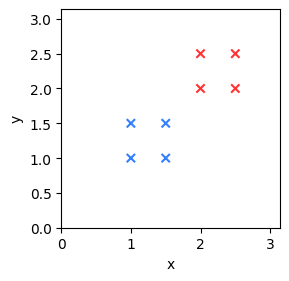

In [4]:
def init_p_with_target():
    # Rectangle [1,1]:[1.5,1.5]
    p_0 = math.tensor([
        [1.0, 1.0],
        [1.0, 1.5],
        [1.5, 1.0],
        [1.5, 1.5]], instance(i=4) & channel(vector='x,y')
    )
    p_target = math.tensor([
        [2.0, 2.0],
        [2.0, 2.5],
        [2.5, 2.0],
        [2.5, 2.5]], instance(i=4) & channel(vector='x,y')
    )
    return (p_0, p_target)

p_0, p_target = init_p_with_target()

vis.plot(vis.overlay(
    PointCloud(p_0, bounds=DOMAIN),
    PointCloud(p_target, bounds=DOMAIN, color="red")
), size=(3,3))

In [37]:
STEPS = 32
DT    = 0.2

def loss_function(w, p, p_target):
    eigenfluid.w = w
    trajectory_p = [p]
    for i in range(STEPS-1):
        # Step velocity
        eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT)
        # Get velocities at new positions
        p_velocities = eigenfluid.get_phi_at(p)
        # Midpoint
        p_velocities = eigenfluid.get_phi_at(p + p_velocities*DT/2)
        # Euler step for points
        p += p_velocities * DT
        trajectory_p.append(p)
    loss = field.l2_loss(p - p_target)
    return (loss, trajectory_p)

gradient_function = math.gradient(loss_function)

In [38]:
# Initialize w to some value for optimization (random or 0)
w_init = math.zeros_like(eigenfluid.w) + 0.001
#w_init = math.random_normal(eigenfluid.w.shape)
p_0, p_target = init_p_with_target()

# first gradient
(loss, trajectory_p), grad = gradient_function(w_init, p_0, p_target)
print("Initial Loss: {}".format(loss))

Initial Loss: 3.9999554


In [42]:
LR = 10**-3

w_optim = w_init
grads = []
for optim_step in range(100):
    (loss, trajectory_p), grad = gradient_function(w_optim, p_0, p_target)
    if optim_step%3 == 0 or optim_step < 5:
        print("Optimization step %d, loss: %f" % (optim_step, loss))
    if optim_step == 20: 
        LR /= 2
        print("LR = {}".format(LR))
    grads.append( grad[0] )
    
    w_optim = w_optim - LR * grads[-1]

Optimization step 0, loss: 3.999955
Optimization step 1, loss: 3.546094
Optimization step 2, loss: 3.137708
Optimization step 3, loss: 2.765172
Optimization step 4, loss: 2.425510
Optimization step 6, loss: 1.844950
Optimization step 9, loss: 1.230693
Optimization step 12, loss: 0.874687
Optimization step 15, loss: 0.670608
Optimization step 18, loss: 0.543560
LR = 0.0005
Optimization step 21, loss: 0.469253
Optimization step 24, loss: 0.433465
Optimization step 27, loss: 0.402145
Optimization step 30, loss: 0.374374
Optimization step 33, loss: 0.349476
Optimization step 36, loss: 0.326949
Optimization step 39, loss: 0.306412
Optimization step 42, loss: 0.287576
Optimization step 45, loss: 0.270210
Optimization step 48, loss: 0.254134
Optimization step 51, loss: 0.239204
Optimization step 54, loss: 0.225299
Optimization step 57, loss: 0.212322
Optimization step 60, loss: 0.200188
Optimization step 63, loss: 0.188827
Optimization step 66, loss: 0.178177
Optimization step 69, loss: 0.168

### Plot Results of Optimization

In [43]:
trajectory_p = math.stack(trajectory_p, batch('time'))
target_time = math.stack([p_target]*STEPS, batch('time'))

#trajectory_v = math.stack(trajectory_v, batch('time'))
#trajectory_curl_ref = math.stack(trajectory_curl, batch('time'))

#velocity_field = math.stack([eigenfluid.reconstruct_velocity()]*STEPS, batch('time'))

vis.plot(vis.overlay(PointCloud(trajectory_p, bounds=DOMAIN),
                     PointCloud(target_time, bounds=DOMAIN, color="red")
                    ),
        animate='time',
        same_scale=False,
        size=(4,4)
)

<Figure size 640x480 with 0 Axes>

# Compare Results with Advection of Smoke Marker

In [44]:
def init_smoke():
    smoke = CenteredGrid(
        Box(x=[p_0.i[0]['x'], p_0.i[3]['x']], y=[p_0.i[0]['y'], p_0.i[1]['y']]), 
        extrapolation.BOUNDARY, 
        x=100, y=100, 
        bounds=DOMAIN
    )
    return smoke

In [45]:
velocity = eigenfluid.reconstruct_velocity()
smoke = init_smoke()

vel_traj = [velocity]
w_traj = [eigenfluid.w]
smoke_traj = [smoke]

start_time = time.time()
for i in range(STEPS-1):
    # Simulate
    w = eigenfluid.step_w_euler(eigenfluid.w, DT)
    velocity = eigenfluid.reconstruct_velocity()
    smoke = advect.mac_cormack(smoke, velocity, dt=DT)
    # Save trajectory
    vel_traj.append(velocity)
    w_traj.append(w)
    smoke_traj.append(smoke)
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

Simulation finished in 6.091506004333496 seconds


In [51]:
trajectory_v = math.stack(vel_traj, batch('time'))
#trajectory_curl = math.stack(trajectory_curl, batch('time'))
trajectory_smoke = math.stack(smoke_traj, batch('time'))

w_VIS_SCALE = 100
w_traj_scaled = [w*w_VIS_SCALE for w in w_traj]
trajectory_w = stack(list(map(get_w_point_cloud, w_traj_scaled)), batch('time'))

vis.plot({
    "Blue points: simulated points\nRed points: target points\nOverlayed with independent\nhigh-res smoke sim.": vis.overlay(PointCloud(trajectory_p, bounds=DOMAIN),
                PointCloud(target_time, bounds=DOMAIN, color="red"),
                trajectory_smoke
    ), 
    "Velocity Field": trajectory_v,
    "w basis coefficients \n(*100 for visualization)": trajectory_w
}, animate='time', same_scale=False)

<Figure size 640x480 with 0 Axes>